In [1]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
# import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import itertools
import random
import tqdm


from typing import*

from collections import*
# from scipy import*
from sklearn.metrics import*

from numpy import *

# import mnist
# bltin_sum = np.sum

import random

from itertools import cycle
from sklearn import*
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
# Functions

# def add(a, b): return a + b

Vector = List[float]

Tensor = list

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

#     return np.sum(v_i * w_i for v_i, w_i in zip(v, w))
#     gen = 
    return np.sum(np.fromiter((v_i * w_i for v_i, w_i in zip(v, w)),float))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

def sigmoid(t: float) -> float: 
    return 1 / (1 + math.exp(-t))

# Gradient Descent - step
def gradient_step(v: Vector, gradient: Vector, step_size: float):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

def is_1d(tensor: Tensor) -> bool:
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensional (that is, a vector).
    """
    return not isinstance(tensor[0], list)

def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Applies f elementwise""" 
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor] 
    
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)


def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]
    
def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the CDF's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2


def num_differences(v1, v2):
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])


def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]


class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")
                
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the
inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

def recolor(pixel):
    cluster = clusterer.classify(pixel)        # index of the closest cluster
    return clusterer.means[cluster]            # mean of the closest cluster

def get_values(cluster):
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]


def cluster_distance(cluster1,
                     cluster2,
                     distance_agg: Callable = min):
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting
list
    """
    return distance_agg([distance(v1, v2) for v1 in get_values(cluster1) for v2 in get_values(cluster2)])

def get_merge_order(cluster):
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order
    
def get_children(cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children
    
class Merged(NamedTuple):
    children: tuple
    order: int

def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min):
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair):
        return cluster_distance(pair[0], pair[1], distance_agg)
 
    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2) 
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster,
                      num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [3]:
# Load dataset
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
dataset = load_breast_cancer()

# Split data into train-test pools 
train, test, train_labels, test_labels = train_test_split(dataset['data'],
                                                          dataset['target'],
                                                          test_size=0.33)

# Train model 
logregr = LogisticRegression().fit(train, train_labels)

test_labels

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [4]:
# Rename, listify 
actuals = list(test_labels)

# Predict probablities of test data [0,1]
scores = list(logregr.predict_proba(test)[:,1])

# Equivalently
import math
def sigmoid(x): 
    return 1 / (1 + math.exp(-x))
# scores = [sigmoid(logregr.coef_@test_i + logregr.intercept_) for test_i in test]
scores

[0.0008934907970151996,
 0.1613672826717624,
 1.2554870782066046e-09,
 0.9953343746429169,
 0.9999281403734658,
 0.9997150674177936,
 0.9834436919025757,
 0.977796481006465,
 0.999827566289287,
 0.024089733397896634,
 0.989412746811127,
 0.01724621922147592,
 1.8163255607797447e-17,
 9.400618420014114e-14,
 0.8663627078802434,
 0.3117313621556746,
 0.9996828602152869,
 0.998621147851376,
 0.9981330947117535,
 0.004476184955668436,
 0.210429693528803,
 0.9850770204898834,
 7.39306835216486e-06,
 4.949528512342613e-20,
 0.998280605637253,
 0.45633534111735014,
 0.008497416659162167,
 0.9939640581317609,
 0.9811278997755752,
 1.4485553641295013e-09,
 0.9999240919225765,
 0.5250184265779444,
 0.0001004050629665974,
 8.511884206718271e-09,
 0.8086714481286755,
 0.9949313777266551,
 0.019332108362881906,
 0.6564426788957639,
 0.9997586719371819,
 2.4024482814815906e-07,
 0.9984144898295064,
 0.23662891695451074,
 0.9982653190732745,
 0.9969440114585392,
 2.896470005438212e-07,
 0.99692488445

In [5]:
# Predict binary outcomes (0,1)
predictions = list(logregr.predict(test))

# Equivalently 
predictions = [1 if s>0.5 else 0 for s in scores]

In [6]:
print("Accuracy = %.3f" % (sum([p==a for p, a in zip(predictions, actuals)])/len(predictions)))

Accuracy = 0.904


In [7]:
import collections
ConfusionMatrix = collections.namedtuple('conf', ['tp','fp','tn','fn']) 

In [8]:
def calc_ConfusionMatrix(actuals, scores, threshold=0.5, positive_label=1):
    tp=fp=tn=fn=0
    bool_actuals = [act==positive_label for act in actuals]
    for truth, score in zip(bool_actuals, scores):
        if score > threshold:                      # predicted positive 
            if truth:                              # actually positive 
                tp += 1
            else:                                  # actually negative              
                fp += 1          
        else:                                      # predicted negative 
            if not truth:                          # actually negative 
                tn += 1                          
            else:                                  # actually positive 
                fn += 1

    return ConfusionMatrix(tp, fp, tn, fn)

In [9]:
def ACC(conf_mtrx):
    return (conf_mtrx.tp + conf_mtrx.tn) / (conf_mtrx.fp + conf_mtrx.tn + conf_mtrx.tp + conf_mtrx.fn)

In [10]:
def FPR(conf_mtrx):
    return conf_mtrx.fp / (conf_mtrx.fp + conf_mtrx.tn) if (conf_mtrx.fp + conf_mtrx.tn)!=0 else 0
def TPR(conf_mtrx):
    return conf_mtrx.tp / (conf_mtrx.tp + conf_mtrx.fn) if (conf_mtrx.tp + conf_mtrx.fn)!=0 else 0

In [11]:
def apply(actuals, scores, **fxns):
    # generate thresholds over score domain 
    low = min(scores)
    high = max(scores)
    step = (abs(low) + abs(high)) / 1000
    thresholds = np.arange(low-step, high+step, step)

    # calculate confusion matrices for all thresholds
    confusionMatrices = []
    for threshold in thresholds:
        confusionMatrices.append(calc_ConfusionMatrix(actuals, scores, threshold))

    # apply functions to confusion matrices 
    results = {fname:list(map(fxn, confusionMatrices)) for fname, fxn in fxns.items()}

    results["THR"] = thresholds
    return results

In [12]:
acc = apply(actuals,  scores, ACC=ACC)

In [13]:
def ROC(actuals, scores):
    return apply(actuals, scores, FPR=FPR, TPR=TPR)

In [14]:
ab = ROC(actuals,scores)
ab['FPR']

[1.0,
 1.0,
 0.5131578947368421,
 0.47368421052631576,
 0.4473684210526316,
 0.4342105263157895,
 0.42105263157894735,
 0.42105263157894735,
 0.42105263157894735,
 0.42105263157894735,
 0.40789473684210525,
 0.40789473684210525,
 0.40789473684210525,
 0.40789473684210525,
 0.39473684210526316,
 0.39473684210526316,
 0.39473684210526316,
 0.39473684210526316,
 0.39473684210526316,
 0.3815789473684211,
 0.3815789473684211,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.3684210526315789,
 0.35526315789473684,
 0.35526315789473684,
 0.35526315789473684,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.34210526315789475,
 0.32894736842105265,
 0.32894

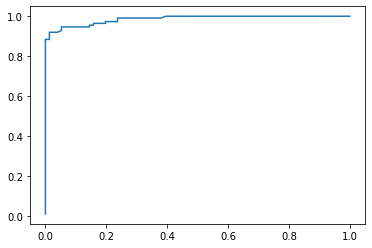

In [15]:
plt.plot(ab['FPR'],ab['TPR'])